In [1]:
require 'unsup';
require 'nn';
require 'gnuplot';
require 'Encoder';
require 'nngraph';
require 'image';
require 'optim';
require 'randomkit'

In [2]:
n_hidden = 50
n_input = 32*32

  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
[torch.LongTensor of size 10x1]



In [5]:
t = torch.Timer()
train = torch.load('mnist.t7/train_32x32.t7', 'ascii')
test = torch.load('mnist.t7/test_32x32.t7', 'ascii')
train = train.data

traindata = torch.Tensor(train:size()[1],1,32,32)
for i = 1,train:size()[1] do   
   traindata[i] = train[i]
end
traindata:div(traindata:std())
--traindata:add(-traindata:mean())
print(t:time().real)

0.40843415260315	


In [6]:
for i = 1,0 do
    print(test)
end

In [7]:
enc = nn.Encoder(1,50,7)

In [8]:
dec = nn.ParallelTable()

declin1 = nn.SpatialConvolution(50, 1, 7, 7)
declin2 = nn.SpatialConvolution(50,1, 7, 7)

decConv1 = nn.Sequential()
decConv1:add(nn.SpatialZeroPadding(3,3,3,3))
decConv1:add(declin1)

decConv2 = nn.Sequential()
decConv2:add(nn.SpatialZeroPadding(3,3,3,3))
decConv2:add(declin2)

declin1:share(declin2,'weight')
declin1:share(declin2,'gradWeight')
declin1.bias = torch.Tensor(1):zero()
declin1.gradBias = torch.Tensor(1):zero() 
declin2.bias = torch.Tensor(1):zero()
declin2.gradBias = torch.Tensor(1):zero() 

dec:add(decConv1)
dec:add(decConv2)


autoencoder = nn.Sequential()
autoencoder:add(enc)
autoencoder:add(dec)


In [9]:
criterion = nn.ParallelCriterion()

xcrit = nn.MSECriterion() --compare x_in and x_out
ycrit = nn.MSECriterion() --compare y_in and y_out

criterion:add(xcrit,0.5)
criterion:add(ycrit,0.5)


In [7]:
parameters, gradParameters = autoencoder:getParameters()

In [8]:
batchsize = 128
config = {learningRate = 0.01,
         weightDecay = 5e-5,
         momentum = 0,
         learningRateDecay = 5e-7}

In [9]:
for i = 1,3000,batchsize do
    
    local feval = function(x)
        if x ~= parameters then
            parameters:copy(x)
        end

        -- reset gradients
        gradParameters:zero()
        local f = 0 
        for j = 0,batchsize-1 do            
            local activity = traindata[i+j]
           -- local phase = torch.Tensor(1,32,32):zero()
            local phase = (torch.rand(1,32,32)*2*math.pi)-math.pi
            local input = {torch.cmul(activity,torch.cos(phase)),torch.cmul(activity,torch.sin(phase)) }
            for k = 1,30 do
                input = {input[1],autoencoder:forward(input)[2]}
            end
            local target = input
            local output = autoencoder:forward(input)
            local err = criterion:forward(output,target) 
            local df_dw = criterion:backward(autoencoder.output,target)
            f = f+err
            autoencoder:backward(input,df_dw)
        end
        gradParameters:div(batchsize)
        f = f/batchsize
        return f, gradParameters
    end 
    
    optim.sgd(feval, parameters, config)

    
    declin1.bias = torch.Tensor(1):zero()
    declin1.gradBias = torch.Tensor(1):zero()
    declin2.bias = torch.Tensor(1):zero()
    declin2.gradBias = torch.Tensor(1):zero()
    enc.convBias = torch.Tensor(50):zero()
    enc.convGradBias = torch.Tensor(50):zero()

end 

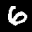

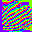

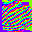

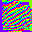

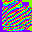

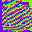

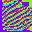

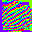

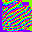

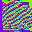

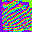

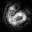

In [20]:
activity = traindata[9001]
phases = torch.Tensor(10,32,32)
images = torch.Tensor(10,3,32,32)
itorch.image(activity)

for i = 1,10 do
        
    local phase = (torch.rand(1,32,32)*2*math.pi)---math.pi
    local inp = {torch.cmul(activity,torch.cos(phase)),torch.cmul(activity,torch.sin(phase))}

    local out = autoencoder:forward(inp)
    local phase_out = torch.atan2(out[2],out[1])
    
    for j = 1,100 do
        out = autoencoder:forward({torch.cmul(activity,torch.cos(phase_out)),torch.cmul(activity,torch.sin(phase_out))})
        phase_out = torch.atan2(out[2],out[1])
    end
    
    a_out = torch.sqrt( torch.pow(out[1],2) + torch.pow(out[2],2 ))


    hsv = torch.Tensor(3,32,32)
    hsv[1]:copy((phase_out+math.pi)/(2*math.pi))
    hsv[2] = torch.Tensor(32,32):fill(0.5)
    hsv[3] = torch.Tensor(32,32):fill(0.5)
    rgb = image.hsv2rgb(hsv)

    phases[i] = phase_out[1]
    itorch.image(rgb)
    images[i] = rgb

    
    
end

local phase_diff  = torch.Tensor(5,32,32)
local j = 1
for i = 1,9,2 do
    phase_diff[j] = phases[i]-phases[i+1]
    phase_diff[j] = phase_diff[j] - (torch.floor(phase_diff[j]/(2*math.pi))*(2*math.pi))
    j = j+1

end

gnuplot.hist(phase_diff,100)
itorch.image(a_out)

In [19]:
image.window()
image.display{image=images[1],gui=true}

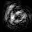

In [19]:
     activity = traindata[9001]
    local phase = torch.Tensor(1,32,32):zero()
    local inp = {torch.cmul(activity,torch.cos(phase)),torch.cmul(activity,torch.sin(phase))}

    local out = autoencoder:forward(inp)

    local a = torch.sqrt( torch.pow(out[1],2) + torch.pow(out[2],2 ))
    local phase_out = torch.atan2(out[2],out[1])
    itorch.image(a)

In [13]:
--print(enc.encoder:get(1):get(1):get(1):get(1):get(2).weight)
print(autoencoder:get(2):get(1):get(2).weight)

(1,1,.,.) = 
 0.01 *
   1.2611 -0.8473 -1.2534  0.7667 -1.0197  1.3611  0.1587
  -0.7366 -1.6457 -0.0911  1.6291  0.3968 -0.1716 -0.5913
  -0.6480  0.2610 -0.5415  1.4744  1.1722  1.5255  1.5203
   1.8299 -0.0868 -0.6398 -0.4011  1.9674  0.8577 -0.7744
  -0.7175 -1.2351  0.9369 -0.1970  0.3153  0.0711 -0.0901
  -1.0962  0.2300  1.5830 -0.4746 -0.4260 -1.1655 -0.2190
  -1.5492 -0.0554 -2.3596 -0.4563 -0.2201  1.7692  1.2032

(1,2,.,.) = 
 0.01 *
   1.6101 -0.5464  0.9492 -0.3697 -0.6782  0.2501 -1.6372
  -0.4758 -1.7697 -1.2595  1.1459  1.4326 -1.7626 -0.5471
  -1.1027  1.2742 -1.8067  0.1646 -1.6907  1.6797  1.7350
   0.2329 -0.0612  1.8025 -0.5294  0.7299  0.8680  0.6041
  -1.8389 -0.5139  0.2940 -1.6801 -0.6721 -0.8408 -0.8556
  -0.6766 -1.3886  1.3542  0.6130 -0.7359  0.9855 -0.7668
  -1.4218 -1.7454  0.3516 -1.4241 -1.7007  0.1243 -1.1511

(1,3,.,.) = 
 0.01 *
   1.8772 -1.6216 -1.8290 -0.6319 -0.2625  1.1802  1.7949
  -1.0072 -1.1139 -0.6564 -1.0278 -0.8202 -1.4313 -1.5928
  -0.31

In [14]:
print(a:get(2):get(1):get(2).weight)

6  1.9858
  -0.9962  1.8019 -1.8851  0.2030  1.2128 -1.2634 -0.6292
  -0.1778  0.5443 -2.1044  1.1213 -0.1219 -0.3266  1.4611
  -1.0861  1.2794  0.3924  1.5320  0.4565 -0.1686  0.7299

(1,11,.,.) = 
 0.01 *
   0.4799 -1.6517  0.0582 -1.5190  1.6428 -1.1342 -0.0874
  -1.2776  0.9614 -1.3206 -0.5716  0.0562 -0.5593 -1.0238
   2.3345  0.5107  0.3341 -0.9349 -1.5577 -1.3860 -1.5745
   0.6236 -1.1512 -2.1527 -0.1789  0.7971 -2.1256  0.0590
  -0.8844  0.9175 -1.0257  1.2393 -2.0490  1.0128 -0.0226
  -1.6617  0.0194 -1.0597  1.7894 -1.5293  1.7678 -1.4696
  -0.0736 -1.5320 -0.2938 -2.1113 -0.1244 -0.2499 -1.7239

(1,12,.,.) = 
 0.01 *
   1.3314  1.2040 -1.9310 -0.7910 -0.4195 -0.1134 -0.7005
   1.5157  0.8768 -0.0160 -2.2324 -1.6072 -1.3685  1.5470
  -1.3075  0.7276  0.1693  1.8989  1.6160  1.2094  2.2363
  -0.7168  0.8390 -0.3433 -0.9300 -1.4302 -1.0635  0.4541
  -2.4875 -0.1943  0.9981  0.8201  0.8437 -0.5696 -0.8091
   0.5419 -1.7999  1.3894  1.3088  1.2824 -1.2196 -1.1695
   0.0392 -1.078

[string "print(a:get(2):get(1):get(2).weight)..."]:1: attempt to index global 'a' (a nil value)
stack traceback:
	[string "print(a:get(2):get(1):get(2).weight)..."]:1: in main chunk
	[C]: in function 'xpcall'
	...bp/projects/phasesim/local/share/lua/5.1/itorch/main.lua:177: in function <...bp/projects/phasesim/local/share/lua/5.1/itorch/main.lua:143>
	...bp/projects/phasesim/local/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	...projects/phasesim/local/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	...projects/phasesim/local/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	...projects/phasesim/local/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	...bp/projects/phasesim/local/share/lua/5.1/itorch/main.lua:344: in main chunk
	[C]: in function 'require'
	[string "arg={'/net/home/student/k/kstandvoss/.ipython..."]:1: in main chunk: 

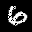

In [53]:
corrupted = torch.cmul(activity,randomkit.binomial(torch.Tensor(#activity),1,0.8))
itorch.image(corrupted)

In [39]:
print('test' .. 'bla')

testbla	


In [38]:
phi = phases[8][torch.gt(activity,0)]
var = 1 - (1/phi:size(1))*(torch.sum(torch.cos(phi))^2 + torch.sum(torch.cos(phi))^2)
print(var)

0.68293357241571	
